<a href="https://colab.research.google.com/github/elenaholubek/skillfactory_DS/blob/main/5_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split#,cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression#,LassoCV,RidgeCV,ElasticNet

from catboost import CatBoostRegressor

# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

# #from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler,MinMaxScaler,PowerTransformer,FunctionTransformer

# from sklearn.linear_model import LinearRegression,LassoCV,RidgeCV,ElasticNet
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor

### importing lazypredict library
import lazypredict
### importing LazyClassifier for classification problem
from lazypredict.Supervised import LazyClassifier
### importing LazyClassifier for classification problem because here we are solving Classification use case.
from lazypredict.Supervised import LazyClassifier

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import StackingRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.svm import SVR
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeRegressor
# 
# from xgboost import XGBRegressor

#from lazypredict.Supervised import LazyClassifier
# from sklearn.metrics import mean_absolute_percentage_error
# import warnings
# warnings.filterwarnings("ignore")

# %matplotlib inline 
# import scipy.stats as stats

In [24]:
!pip install catboost

     |████████████████████████████████| 76.4 MB 33 kB/s 


## READ DATA

In [1]:
# local only:
#df_test = pd.read_csv('test.csv')
# df_train = pd.read_csv('train.csv')
#df_sub = pd.read_csv('sample_submission.csv')


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# load processed dataset:
data =pd.read_csv('/content/drive/My Drive/ML/data_ML.csv')
# data = pd.read_csv('data_dum.csv')
# data = df_train = pd.read_csv('data_noouts.csv')
# data = pd.read_csv('data_noouts_dum.csv')



In [8]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


In [9]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63861 entries, 0 to 63860
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         63861 non-null  int64  
 1   model_name    63861 non-null  int64  
 2   body_type     63861 non-null  int64  
 3   doors         63861 non-null  int64  
 4   color         63861 non-null  int64  
 5   engine_V      63861 non-null  float64
 6   power         63861 non-null  float64
 7   fuel          63861 non-null  int64  
 8   mileage       63861 non-null  float64
 9   transmission  63861 non-null  int64  
 10  owners        63861 non-null  int64  
 11  pass          63861 non-null  int64  
 12  drive         63861 non-null  int64  
 13  wheel         63861 non-null  int64  
 14  price         63861 non-null  int64  
 15  test_train    63861 non-null  object 
 16  model_age     63861 non-null  float64
 17  new_model     63861 non-null  int64  
 18  car_age       63861 non-nu

In [10]:
data.describe()


,brand,model_name,body_type,doors,color,engine_V,power,fuel,mileage,transmission,owners,pass,drive,wheel,price,model_age,new_model,car_age,new_car,retro,raritet,electrocar,petrol_car,1_owner
count,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,6.386100e+04,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000,63861.000000
mean,5.358920,248.972926,9.133133,3.515197,6.300496,1.195413,5.175884,3.324674,11.630192,1.372246,1.155009,0.861308,0.635944,0.058095,8.498874e+05,2.437903,0.000376,2.437903,0.000376,0.024052,0.000658,0.001863,0.819185,0.295814
std,3.507324,139.309573,8.617570,0.685272,5.299492,0.256904,0.424333,1.481012,1.092305,0.908316,0.850071,0.345627,0.663191,0.233925,1.608819e+06,0.558826,0.019382,0.558826,0.019382,0.153213,0.025637,0.043127,0.384867,0.456412
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.530628,3.433987,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,114.000000,0.000000,3.000000,1.000000,1.029619,4.912655,4.000000,11.321777,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,2.079442,0.000000,2.079442,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,5.000000,279.000000,8.000000,4.000000,6.000000,1.098612,5.159055,4.000000,11.856522,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000e+00,2.484907,0.000000,2.484907,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,8.000000,398.000000,19.000000,4.000000,12.000000,1.386294,5.497168,4.000000,12.235636,2.000000,2.000000,1.000000,1.000000,0.000000,1.190000e+06,2.772589,0.000000,2.772589,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,11.000000,412.000000,23.000000,4.000000,15.000000,2.028148,6.508769,4.000000,13.815512,3.000000,2.000000,1.000000,2.000000,1.000000,3.999000e+07,4.762174,1.000000,4.762174,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
data.isna().sum()


brand           0
model_name      0
body_type       0
doors           0
color           0
engine_V        0
power           0
fuel            0
mileage         0
transmission    0
owners          0
pass            0
drive           0
wheel           0
price           0
test_train      0
model_age       0
new_model       0
car_age         0
new_car         0
retro           0
raritet         0
electrocar      0
petrol_car      0
1_owner         0
dtype: int64

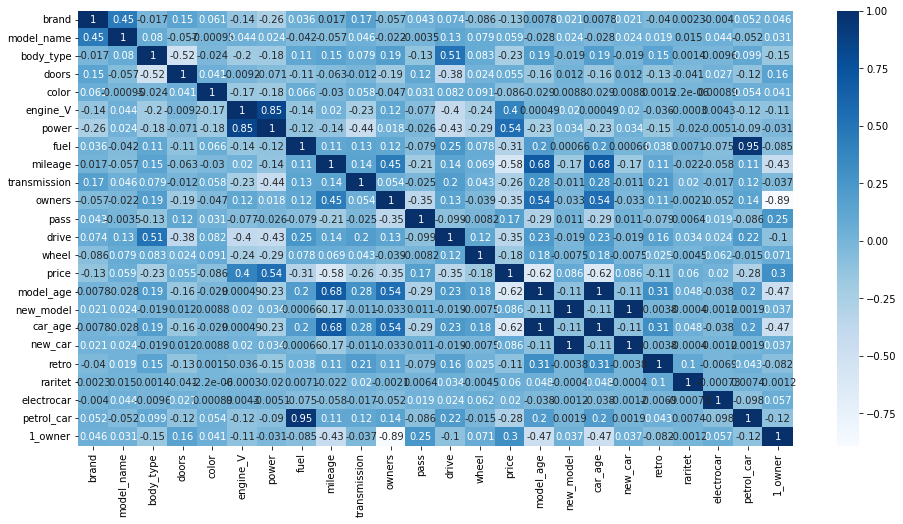

In [12]:
# heatmap 
plt.figure(figsize=(16,8))
sns.heatmap(data[data.test_train=="train"].corr(),annot=True, cmap="Blues")


Глядя на матрицу, можно сделать очевидные выводы

Привод и количество дверей как-то зависят от типа кузова
Цена зависима (обратно) от пробега и возраста
Пробег скоррелирован с возрастом
Высокая корреляция присутствует между (model_age и car_age) и между (new_car и new_model) и (fuel и petrol_car) признаками Посмотрим на значимость признаков, уберем model_age и new_model





In [13]:
used_features = list(data.columns)
used_features.remove("test_train")
used_features.remove("price")
used_features


['brand',
 'model_name',
 'body_type',
 'doors',
 'color',
 'engine_V',
 'power',
 'fuel',
 'mileage',
 'transmission',
 'owners',
 'pass',
 'drive',
 'wheel',
 'model_age',
 'new_model',
 'car_age',
 'new_car',
 'retro',
 'raritet',
 'electrocar',
 'petrol_car',
 '1_owner']

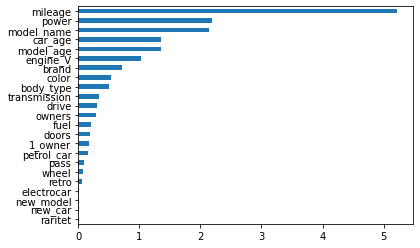

In [14]:
# посмотрим на значимость признаков:
imp_cat = pd.Series(mutual_info_classif(data[data['price']>0][used_features],
                                     data[data['price']>0]['price'],
                                     discrete_features = True), index=used_features)
#plt.figure(figsize=(15,15))
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')


 Самый важный признак - пробег, а также мощность, имя модели, возраст, объем двигателя, марка и цвет
 
 удалим  скореллированные признаки, так как на цену они влтяют одинаково в данном датасете

In [ ]:
data.drop(["model_age", "new_model", "petrol_car"], axis=1, inplace=True)


In [15]:
used_features.remove("model_age")
used_features.remove("petrol_car")
used_features.remove("new_model")


## ML

разделяем датасеты

In [16]:
df_train = data[data.test_train == "train"].drop("test_train", axis=1)
df_test = data[data.test_train == "test"].drop(['price', 'test_train'], axis=1)


Назначаем целевую переменную и производим разбивку train данных

In [17]:
y = df_train["price"]
X = df_train.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


### Normalization:

In [ ]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)


## 1. Наивная модель

In [18]:
y = df_train["price"]
X = df_train.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [19]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train


In [21]:
# Находим median по экземплярам enginepower в трейне и размечаем тест
predict = X_test['power'].map(
    tmp_train.groupby('power')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")


Точность наивной модели по метрике MAPE: 66.57%


### result:   66.57%

## 2. CatBoost

Столкнулась с неразрешимой проблемой на всех имеющихся во владении компьютерах

https://stackoverflow.com/questions/47022997/jupyter-the-kernel-appears-to-have-died-it-will-restart-automatically
    
На colab отработало хорошо, результат получился 14.90%

In [22]:
y = df_train["price"]
X = df_train.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=42)


In [26]:
model = CatBoostRegressor(iterations=5000,
                          random_seed=42,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          )
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=0,
          use_best_model=True,
          )

model.save_model('catboost_single_model_baseline.model')


In [27]:
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")


Точность модели по метрике MAPE: 14.90%


In [ ]:
# Normalization:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

### 3. LINEAR REGRESSION

In [28]:
from sklearn.model_selection import train_test_split

linreg = LinearRegression().fit(X_train, np.log(y_train+1))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(linreg.predict(X_test))))*100:0.2f}%")
predict_test = np.exp(linreg.predict(X_test))


Точность модели по метрике MAPE: 27.95%


In [29]:
# Normalization:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [30]:
linreg = LinearRegression().fit(X_train, np.log(y_train+1))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(linreg.predict(X_test))))*100:0.2f}%")
predict_test = np.exp(linreg.predict(X_test))

Точность модели по метрике MAPE: 27.95%


Нормализация не уменьшила ошибку

### result: 27.95%

### 4.  Gradientboosting regressor

In [31]:
grb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03,
                                max_depth=10, n_estimators=300, random_state=42)
grb.fit(X_train, np.log(y_train+1))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(grb.predict(X_test))))*100:0.2f}%")
predict_test = np.exp(grb.predict(X_test))


Точность модели по метрике MAPE: 13.87%


### result: 13.94%

### 5. LogisticRegression

работает долго

In [ ]:
from sklearn.linear_model import LogisticRegression 

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(lr.predict(X_test))))*100:0.2f}%")
